## Dataset loading using braindecode

In [1]:
import braindecode

<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [2]:
import torch
from braindecode.models import EEGNetv4, EEGConformer, ATCNet, EEGITNet, EEGInception
from braindecode.datasets import MOABBDataset

In [3]:
raw_dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=None)

Preprocess dataset using braindecode API

In [4]:
from braindecode.preprocessing import create_windows_from_events
from braindecode.preprocessing import exponential_moving_standardize, preprocess, Preprocessor

In [5]:
# low_freq = 4
# high_freq = 38
# resample_freq = 250

# # preprocess data using "braindecode.preprocessor"
# # only use eeg(stim channels must be removed)
# preprocessors = [Preprocessor('pick', picks=['eeg'])]

# # if pick_channels:
# #     preprocessors.append(Preprocessor('pick', picks=pick_channels))
# # preprocessors.append(Preprocessor(lambda data: multiply(data, 1e6)))


# # if low_freq or high_freq:
#     # preprocessors.append(Preprocessor('filter', l_freq=low_freq, h_freq=high_freq))
# if resample_freq:
#     preprocessors.append(Preprocessor('resample', sfreq=resample_freq))
# preprocessors.append(Preprocessor(exponential_moving_standardize, factor_new=1e-3))
# preprocess(raw_dataset, preprocessors)

# from braindecode.preprocessing import MNEPreproc, NumpyPreproc, preprocess

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    # keep only EEG sensors
    Preprocessor(fn='pick_types', eeg=True, meg=False, stim=False),
    # convert from volt to microvolt, directly modifying the numpy array
    Preprocessor(fn=lambda x: x * 1e6),
    # bandpass filter
    Preprocessor(fn='filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    # exponential moving standardization
    Preprocessor(fn=exponential_moving_standardize, factor_new=factor_new,
        init_block_size=init_block_size)
]

# Preprocess the data
preprocess(raw_dataset, preprocessors)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Window Split (for each trail start and end)

In [6]:
start_offset = -0.5
stop_offset = 0

sfreq = raw_dataset.datasets[0].raw.info['sfreq']
#assert all([ds.raw.info['sfreq'] == sfreq for ds in raw_dataset.datasets])
trial_start_offset_samples = int(start_offset * sfreq)
trial_stop_offset_samples = int(stop_offset * sfreq)

windows_dataset = create_windows_from_events(
    raw_dataset,
    trial_start_offset_samples,
    trial_stop_offset_samples,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

In [7]:
import pandas as pd
df = pd.DataFrame(windows_dataset.get_metadata())
df.to_csv('windows_dataset.csv')
windows_dataset.get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,session,run
0,0,125,1250,3,1,0train,0
1,0,2128,3253,0,1,0train,0
2,0,4046,5171,2,1,0train,0
3,0,5998,7123,1,1,0train,0
4,0,8006,9131,1,1,0train,0
...,...,...,...,...,...,...,...
43,0,86625,87750,0,9,1test,5
44,0,88531,89656,3,9,1test,5
45,0,90459,91584,0,9,1test,5
46,0,92573,93698,1,9,1test,5


In [8]:
import numpy as np

In [9]:
meta_windows = windows_dataset.get_metadata()
np.unique(meta_windows['session'], return_counts = True)

(array(['0train', '1test'], dtype=object), array([2592, 2592], dtype=int64))

Get additional dataset details and set model configuration

In [10]:
n_channels = raw_dataset[0][0].shape[0]
n_times = windows_dataset[0][0].shape[1]
n_classes = 4 # number of classes in the dataset used

n_epochs = 100
lr = 0.001
batch_size = 64

# variables to save the model
save = 'store_true'
save_dir = 'models/'
strategy = 'within-subject' # 'within-subject' or 'cross-subject'
model_name = 'EEGNet' # 'EEGNet', 'EEGConformer', 'ATCNet', 'EEGITNet', 'EEGInception'
verbose = 2

Split data  into test and train based on window subset

In [11]:
from skorch.helper import SliceDataset
from skorch.callbacks import LRScheduler, TrainEndCheckpoint
from skorch import NeuralNetClassifier

cuda = torch.cuda.is_available()


In [12]:
X = []
y = []
for i in range(len(windows_dataset)):
    x, target, window_ind = windows_dataset[i]
    # print(f"Shape of window {i}: {x.shape}, Label: {target}")
    X.append(x)
    y.append(target)

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [14]:
X = np.array(X)
enc = OneHotEncoder()
y = enc.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

In [28]:
print("Train class split:")
unique_elements, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
for value, count in zip(unique_elements, counts):
    print(f"{value}: {count}")
print("Test class split:")
unique_elements, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
for value, count in zip(unique_elements, counts):
    print(f"{value}: {count}")

Train class split:
0: 1031
1: 1059
2: 1034
3: 1023
Test class split:
0: 265
1: 237
2: 262
3: 273


In [23]:
X_train.shape

(3628, 22, 1125)

In [24]:
y_train.shape

(3628, 4)

In [25]:
np.unique(np.argmax(y_test, axis=1),return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([404, 359, 390, 403], dtype=int64))

In [26]:
np.unique(np.argmax(y_train, axis=1),return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([892, 937, 906, 893], dtype=int64))

In [103]:
from sklearn.metrics import *

In [110]:
def test_metrics(model, X_test = X_test):
    pred = model.predict(X_test)
    print(np.argmax(y_test, axis=1)[0])
    print(pred[0])
    print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), pred))
    print("Precision: ", precision_score(np.argmax(y_test, axis=1), pred, average='weighted'))
    print("Recall: ", recall_score(np.argmax(y_test, axis=1), pred, average='weighted'))
    print("F1: ", f1_score(np.argmax(y_test, axis=1), pred, average='weighted'))

In [119]:
def test_metrics_onehot(model, X_test = X_test):
    pred = model.predict(X_test)
    i=0
    for a in pred:
        temp = [0, 0, 0, 0] 
        temp[np.argmax(a)] = 1
        pred[i] = temp
        i+=1
    print(y_test[0])
    print(pred[0])
    print("Accuracy: ", accuracy_score(y_test, pred))
    print("Precision: ", precision_score(y_test, pred, average='weighted'))
    print("Recall: ", recall_score(y_test, pred, average='weighted'))
    print("F1: ", f1_score(y_test, pred, average='weighted'))

In [98]:
import numpy as np
import os
import mne
from scipy.io import loadmat

def add_awgn_noise(signal, snr):
    """
    Add AWGN noise to the signal based on a desired SNR.
    Args:
        signal (numpy.array): Original EEG signals.
        snr (float): Desired signal-to-noise ratio in dB.
    Returns:
        numpy.array: Signal with added Gaussian noise.
    """
    sig_power = np.mean(np.power(signal, 2))
    sig_db = 10 * np.log10(sig_power)
    noise_db = sig_db - snr
    noise_power = np.power(10, noise_db / 10)
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    noisy_signal = signal + noise
    return noisy_signal
def create_noisy_dataset(data, snr):
    """
    Apply AWGN to each sample in the dataset.
    Args:
        data (numpy.array): Original EEG dataset.
        snr (float): Desired signal-to-noise ratio.
    Returns:
        numpy.array: Noisy EEG dataset.
    """
    noisy_data = np.array([add_awgn_noise(sample, snr) for sample in data])
    return noisy_data

from numpy import dot
from numpy.linalg import norm

def cosine_similarity(arr1, arr2):
    return dot(arr1.flatten(), arr2.flatten()) / (norm(arr1) * norm(arr2))


In [101]:
X_test_noise = create_noisy_dataset(X_test, snr = 15)
similarity = cosine_similarity(X_test_noise, X_test)
print("Similarity with original data: ",similarity)

Similarity with original data:  0.9848849039870671


In [27]:
from sklearn.metrics import *
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

In [28]:
cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 16)

In [29]:
def CV_train(model, X, X_test, cnn = False, convlstm = False, batch_size = 32, n_epochs = 50, y_out = y_train, y_out_test = y_test):
    acc = []
    f1 = []
    prec = []
    recall = []
    results = {}
    best_model = model
    prev_metric = 0
    best_hist = []
    for train_idx, val_idx in cv.split(y_out):

        nn = [] 

        label_train, _ = y_out[train_idx], y_out[val_idx]
        y_train, y_val = y_out[train_idx], y_out[val_idx] 

        X_train = X[train_idx] 
        X_val = X[val_idx] 
        
        if cnn:
            X_train = np.expand_dims(X_train,-1)
        elif convlstm:
            X_train = np.expand_dims(np.expand_dims(X_train, -1),-1)

        nn = model

        history = nn.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = batch_size, epochs = n_epochs)

        y_pred = nn.predict(X_val)
        pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

        acc_score = accuracy_score(y_val.argmax(axis=1), pred.argmax(axis=1))
        acc.append(acc_score)
        f1_val = (f1_score(y_val.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
        f1.append(f1_val)
        prec.append(precision_score(y_val.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
        recall.append(recall_score(y_val.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
        if f1_val > prev_metric: 
            prev_metric = f1_val
            best_model = model
            best_hist = history
    
    test_pred = best_model.predict(X_test)
    pred = (test_pred == test_pred.max(axis=1)[:,None]).astype(int)
    acc.append(accuracy_score(y_out_test.argmax(axis=1), pred.argmax(axis=1)))
    f1.append(f1_score(y_out_test.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
    prec.append(precision_score(y_out_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
    recall.append(recall_score(y_out_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
    
    results['Accuracy'] = acc
    results['F1'] = f1
    results['Precision'] = prec
    results['Recall'] = recall

    plt.plot(best_hist.history['loss'], label='Training Loss')
    plt.plot(best_hist.history['val_loss'], label='Validation Loss', color = 'b')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.plot(best_hist.history['accuracy'], label='Training Accuracy')
    plt.plot(best_hist.history['val_accuracy'], label='Validation Accuracy', color = 'b')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return best_model, results

In [30]:
import mne 
import numpy as np
import pandas as pd
import torch
import os
import braindecode
import matplotlib.pyplot as plt
from braindecode.models import EEGNetv4, EEGConformer, ATCNet, EEGITNet, EEGInception
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import create_windows_from_events
from braindecode.preprocessing import exponential_moving_standardize, preprocess, Preprocessor

import scipy.io
import pywt
from mne.decoding import CSP # Common Spatial Pattern Filtering
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Reshape, ConvLSTM1D, Conv2D
from keras import regularizers
from sklearn import preprocessing
from sklearn.metrics import *
from sklearn.model_selection import ShuffleSplit

In [31]:
def build_mlp_classifier(num_layers = 1, lr = 0.01):
    classifier = Sequential()
    classifier.add(Flatten())
    #First Layer
    classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', 
                         kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
    classifier.add(Dropout(0.4))
    # Intermediate Layers
    for itr in range(num_layers):
        classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', 
                             kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
        classifier.add(Dropout(0.4))   
    # Last Layer
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = keras.optimizers.Adam(lr=lr) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier

Epoch 1/30


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 5s 29ms/step - loss: 42.8814 - accuracy: 0.2429 - val_loss: 31.9970 - val_accuracy: 0.2713
Epoch 2/30
91/91 [==============================] - 2s 25ms/step - loss: 24.5837 - accuracy: 0.2553 - val_loss: 18.2145 - val_accuracy: 0.2713
Epoch 3/30
91/91 [==============================] - 2s 25ms/step - loss: 13.9372 - accuracy: 0.2550 - val_loss: 10.2966 - val_accuracy: 0.2713
Epoch 4/30
91/91 [==============================] - 2s 26ms/step - loss: 7.9073 - accuracy: 0.2550 - val_loss: 5.9000 - val_accuracy: 0.2713
Epoch 5/30
91/91 [==============================] - 2s 25ms/step - loss: 4.6204 - accuracy: 0.2550 - val_loss: 3.5622 - val_accuracy: 0.2713
Epoch 6/30
91/91 [==============================] - 2s 26ms/step - loss: 2.9099 - accuracy: 0.2550 - val_loss: 2.3799 - val_accuracy: 0.2713
Epoch 7/30
91/91 [==============================] - 2s 25ms/step - loss: 2.0653 - accuracy: 0.2536 - val_loss: 1.8145 - val_accuracy: 0.2713
Epoch 8/30
91/91 [

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 0s 4ms/step


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


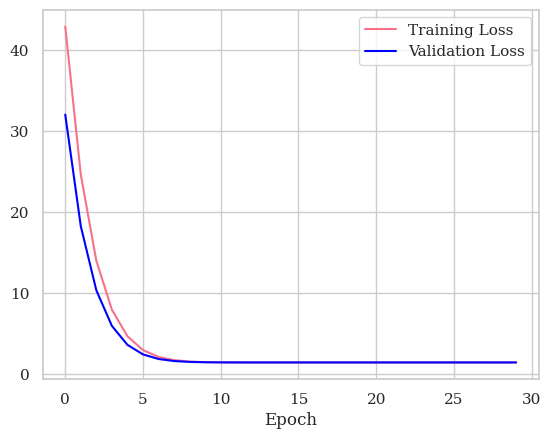

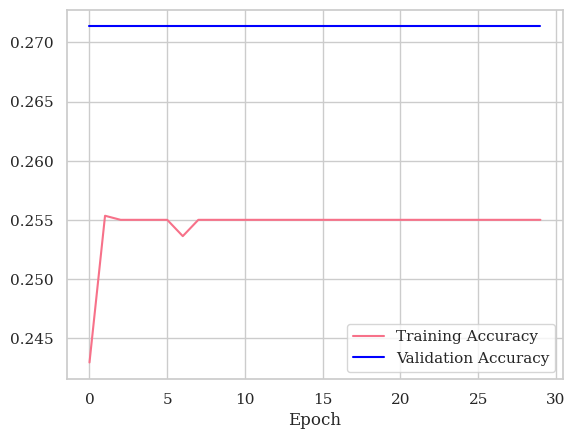

In [71]:
mlp = build_mlp_classifier(8, 0.0001)
mlp, mlp_results = CV_train(mlp, X_train, X_test, n_epochs=30)

In [73]:
mlp_results

{'Accuracy': [0.2713498622589532, 0.230719794344473],
 'F1': [0.11583081877576115, 0.08650486284038204],
 'Precision': [0.07363074774795286, 0.05323162350235592],
 'Recall': [0.2713498622589532, 0.230719794344473]}

In [120]:
test_metrics_onehot(mlp, X_test_noise)

49/49 [==============================] - 0s 5ms/step
[0. 0. 0. 1.]
[0. 1. 0. 0.]
Accuracy:  0.230719794344473
Precision:  0.05323162350235592
Recall:  0.230719794344473
F1:  0.08650486284038204


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
mlp.save_weights('models/mlp.h5')

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [34]:
def build_eegnet_classifier(nb_classes=4, Chans = 22, Samples = 1125, 
             dropoutRate = 0.3, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    classifier = Model(inputs=input1, outputs=softmax)
    classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier

In [35]:
X_train.shape

(3628, 22, 1125)

Epoch 1/100
91/91 [==============================] - 16s 155ms/step - loss: 1.3548 - accuracy: 0.3270 - val_loss: 1.3735 - val_accuracy: 0.2755
Epoch 2/100
91/91 [==============================] - 14s 151ms/step - loss: 1.2564 - accuracy: 0.4214 - val_loss: 1.3080 - val_accuracy: 0.3857
Epoch 3/100
91/91 [==============================] - 13s 144ms/step - loss: 1.2137 - accuracy: 0.4524 - val_loss: 1.2262 - val_accuracy: 0.4890
Epoch 4/100
91/91 [==============================] - 13s 145ms/step - loss: 1.1953 - accuracy: 0.4673 - val_loss: 1.1853 - val_accuracy: 0.4904
Epoch 5/100
91/91 [==============================] - 14s 150ms/step - loss: 1.1784 - accuracy: 0.4645 - val_loss: 1.1486 - val_accuracy: 0.4876
Epoch 6/100
91/91 [==============================] - 13s 147ms/step - loss: 1.1685 - accuracy: 0.4769 - val_loss: 1.1392 - val_accuracy: 0.4931
Epoch 7/100
91/91 [==============================] - 14s 151ms/step - loss: 1.1549 - accuracy: 0.4848 - val_loss: 1.1176 - val_accuracy:

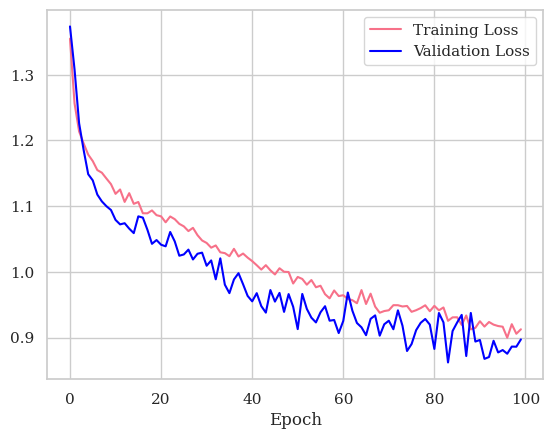

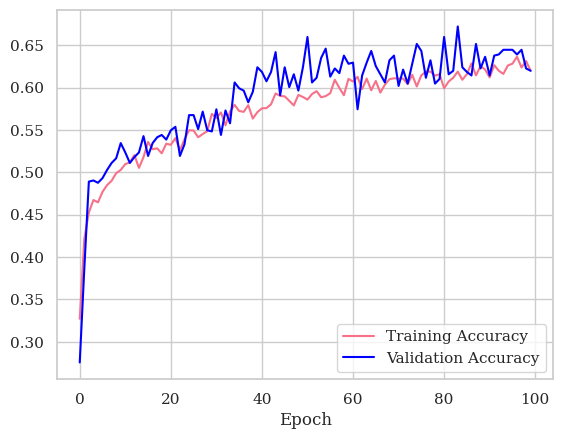

In [36]:
eegnet = build_eegnet_classifier()
eegnet, eegnet_results = CV_train(eegnet, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=100)

In [74]:
eegnet_results

{'Accuracy': [0.6198347107438017, 0.5841902313624678],
 'F1': [0.6096898011200558, 0.5797141801858597],
 'Precision': [0.6568467998033982, 0.6348330386035307],
 'Recall': [0.6198347107438017, 0.5841902313624678]}

In [37]:
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000)) 


In [38]:
def build_shallow_conv_net(nb_classes=4, Chans = 22, Samples = 1125, dropoutRate = 0.5):
    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(40, (1, 13), 
                        input_shape=(Chans, Samples, 1),
                        kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    return Model(inputs=input_main, outputs=softmax)

Epoch 1/100


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 15s 158ms/step - loss: 1.5165 - accuracy: 0.3053 - val_loss: 1.4213 - val_accuracy: 0.3898
Epoch 2/100
91/91 [==============================] - 13s 143ms/step - loss: 1.3525 - accuracy: 0.3980 - val_loss: 1.2936 - val_accuracy: 0.4353
Epoch 3/100
91/91 [==============================] - 12s 135ms/step - loss: 1.2652 - accuracy: 0.4438 - val_loss: 1.3605 - val_accuracy: 0.4132
Epoch 4/100
91/91 [==============================] - 12s 134ms/step - loss: 1.2069 - accuracy: 0.4773 - val_loss: 1.3112 - val_accuracy: 0.4256
Epoch 5/100
91/91 [==============================] - 12s 135ms/step - loss: 1.1803 - accuracy: 0.4976 - val_loss: 1.3386 - val_accuracy: 0.4601
Epoch 6/100
91/91 [==============================] - 12s 136ms/step - loss: 1.1700 - accuracy: 0.5017 - val_loss: 1.2913 - val_accuracy: 0.4449
Epoch 7/100
91/91 [==============================] - 12s 134ms/step - loss: 1.1028 - accuracy: 0.5207 - val_loss: 1.2452 - val_accuracy: 0.4477
Epoc

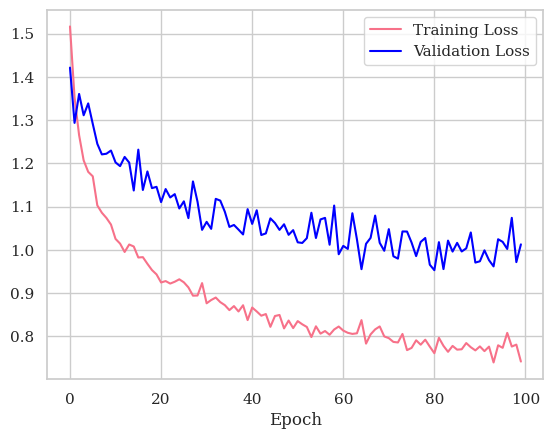

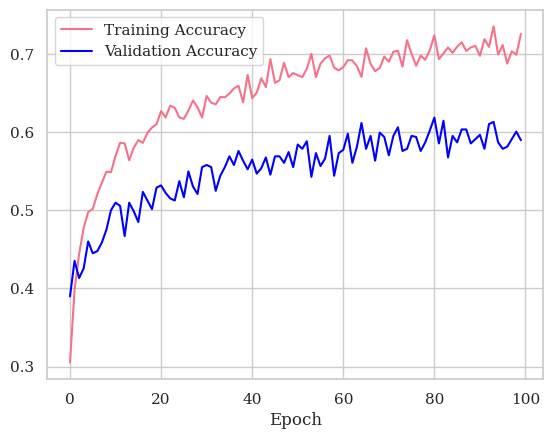

In [39]:
scn = build_shallow_conv_net()
scn.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
scn, scn_results = CV_train(scn, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=100)

In [75]:
scn_results

{'Accuracy': [0.5895316804407713, 0.5616966580976864],
 'F1': [0.5889543831013321, 0.5631731266254489],
 'Precision': [0.6085939356822695, 0.5848636155519277],
 'Recall': [0.5895316804407713, 0.5616966580976864]}

In [127]:
# scn.predict(np.expand_dims(X_test_noise,-1))
test_metrics_onehot(scn, np.expand_dims(X_test_noise,-1))

49/49 [==============================] - 2s 37ms/step
[0. 0. 0. 1.]
[0. 0. 1. 0.]
Accuracy:  0.5295629820051414
Precision:  0.5604091429641811
Recall:  0.5295629820051414
F1:  0.531671888438426


In [95]:
scn.save_weights('models/scn.h5')

In [40]:
def build_deep_conv_net(nb_classes=4, Chans = 22, Samples = 1125, dropoutRate = 0.5):
    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

Epoch 1/100


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 14s 142ms/step - loss: 1.7995 - accuracy: 0.2674 - val_loss: 1.4654 - val_accuracy: 0.2672
Epoch 2/100
91/91 [==============================] - 13s 139ms/step - loss: 1.6869 - accuracy: 0.2994 - val_loss: 1.9686 - val_accuracy: 0.2576
Epoch 3/100
91/91 [==============================] - 13s 144ms/step - loss: 1.5419 - accuracy: 0.3336 - val_loss: 2.0670 - val_accuracy: 0.2672
Epoch 4/100
91/91 [==============================] - 14s 149ms/step - loss: 1.5419 - accuracy: 0.3449 - val_loss: 1.7798 - val_accuracy: 0.2769
Epoch 5/100
91/91 [==============================] - 13s 147ms/step - loss: 1.5122 - accuracy: 0.3584 - val_loss: 1.4918 - val_accuracy: 0.2893
Epoch 6/100
91/91 [==============================] - 13s 141ms/step - loss: 1.4293 - accuracy: 0.3656 - val_loss: 1.6981 - val_accuracy: 0.2948
Epoch 7/100
91/91 [==============================] - 13s 143ms/step - loss: 1.4174 - accuracy: 0.3856 - val_loss: 1.9813 - val_accuracy: 0.2631
Epoc

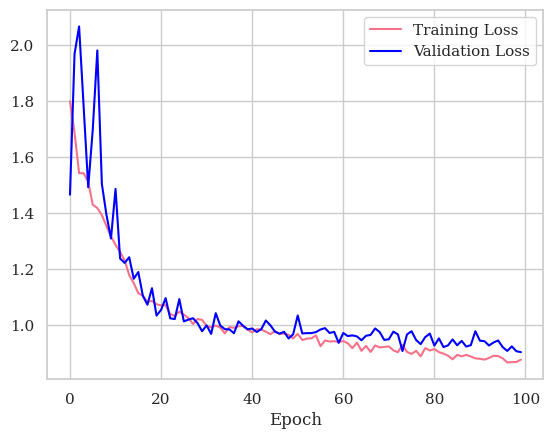

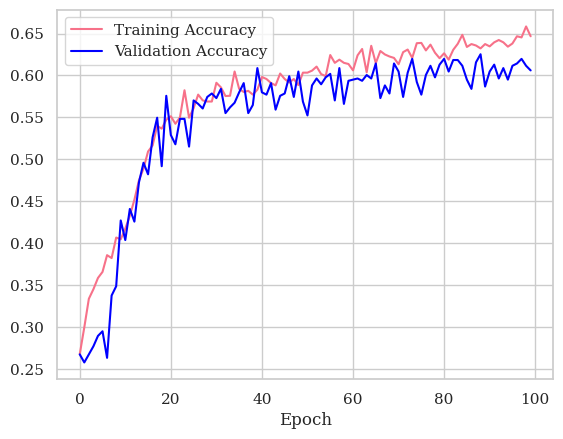

In [41]:
dcn = build_deep_conv_net()
dcn.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
dcn, dcn_results = CV_train(dcn, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=100)

In [76]:
dcn_results

{'Accuracy': [0.6060606060606061, 0.5989717223650386],
 'F1': [0.6019596527107984, 0.593435124363245],
 'Precision': [0.6093951398165224, 0.5993684559209379],
 'Recall': [0.6060606060606061, 0.5989717223650386]}

In [129]:
test_metrics_onehot(dcn, np.expand_dims(X_test_noise,-1))

49/49 [==============================] - 2s 40ms/step
[0. 0. 0. 1.]
[0. 1. 0. 0.]
Accuracy:  0.5764781491002571
Precision:  0.574437470230446
Recall:  0.5764781491002571
F1:  0.5740812512286723


In [96]:
dcn.save_weights('models/dcn.h5')

In [42]:
callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),]
eegv4 = NeuralNetClassifier(module=EEGNetv4,
        module__n_chans=22,
        module__n_outputs=4,
        module__n_times=1125,
        module__kernel_length=32,
        module__drop_prob=0.5,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=0.001,
        train_split=None,
        iterator_train__shuffle=True,
        batch_size=32,
        callbacks=callbacks,
        device='cuda' if cuda else 'cpu',
        verbose=verbose
        )

eegv4.fit(X_train, y_train, epochs=100)

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4427  0.0010  2.1633
      2        1.3859  0.0010  1.0173
      3        1.3483  0.0010  1.0217
      4        1.2992  0.0010  1.0263
      5        1.2787  0.0010  1.0934
      6        1.2382  0.0010  1.0488
      7        1.1980  0.0010  1.0503
      8        1.1891  0.0010  1.0460
      9        1.1617  0.0010  1.0734
     10        1.1502  0.0010  1.0381
     11        1.1367  0.0010  1.0854
     12        1.1052  0.0010  1.0298
     13        1.0936  0.0010  1.0209
     14        1.1000  0.0010  1.0630
     15        1.0881  0.0010  1.0098
     16        1.0833  0.0009  1.0130
     17        1.0864  0.0009  1.0293
     18        1.0629  0.0009  1.0698
     19        1.0767  0.0009  1.0149
     20        1.0565  0.0009  1.0196
     21        1.0507  0.0009  1.0830
     22        1.0563  0.0009  1.0412
     23        1.0358  0.0009  1.0175
     24        1.0458  0.0009  1.0258
     25     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  EEGNetv4 (EEGNetv4)                                [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                       [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2                      [1, 22, 1125, 1]          [1, 1, 22, 1125]          --                        --
  ├─Conv2d (conv_temporal): 1-3                      [1, 1, 22, 1125]          [1, 8, 22, 1126]          256                       [1, 32]
  ├─BatchNorm2d (bnorm_temporal): 1-4                [1, 8, 22, 1126]          [1, 8, 22, 11

In [137]:
test_metrics(eegv4)

3
1
Accuracy:  0.6034704370179949
Precision:  0.6043251644427647
Recall:  0.6034704370179949
F1:  0.5938582560554304


In [135]:
X_test.shape

(1556, 22, 1125)

In [136]:
X_test_noise.shape

(1556, 22, 1125)

In [145]:
test_metrics(eegv4, X_test = X_test_noise.astype(double))

NameError: name 'double' is not defined

Train Accuracy:  0.7003858875413451
Test Accuracy:  0.6034704370179949


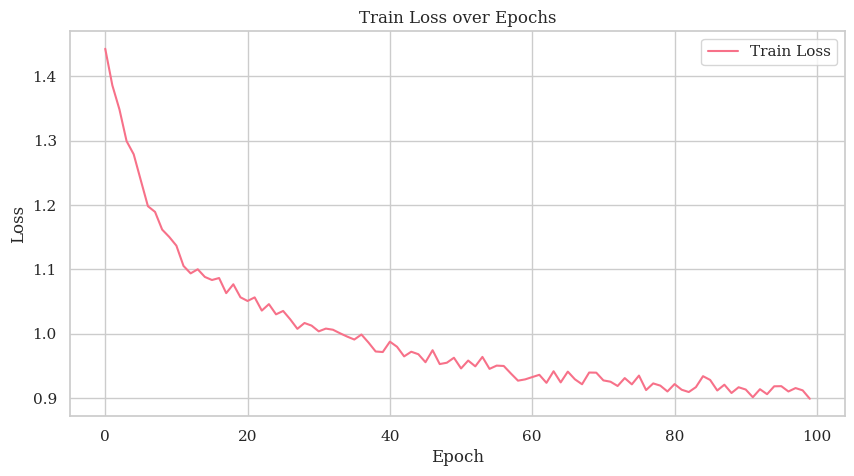

In [43]:
print("Train Accuracy: ", eegv4.score(X_train, np.argmax(y_train, axis=1)))
print("Test Accuracy: ", eegv4.score(X_test, np.argmax(y_test, axis=1)))

train_loss = eegv4.history[:, 'train_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
eegv4.save_weights('models/eegv4.h5')

AttributeError: 'NeuralNetClassifier' object has no attribute 'save_weights'

In [44]:
from braindecode.models import *

In [45]:
callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))]
atcnet = NeuralNetClassifier(module=ATCNet,
        module__n_chans=22,
        module__n_outputs=4,
        module__n_times=1125,
        module__add_log_softmax=False,
        # module__kernel_length=32,
        # module__drop_prob=0.5,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=0.001,
        train_split=None,
        iterator_train__shuffle=True,
        batch_size=32,
        callbacks=callbacks,
        device='cuda' if cuda else 'cpu',
        verbose=verbose
        )
# clf.callbacks.append(TrainEndCheckpoint(dirname=save_dir + f'\\S{subject}'))
atcnet.fit(X_train, y_train, epochs=100)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1041.)
  return F.conv2d(input, weight, bias, self.stride,


  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4108  0.0010  5.8969
      2        1.3276  0.0010  5.8704
      3        1.2761  0.0010  5.8980
      4        1.2278  0.0010  5.7995
      5        1.1883  0.0010  5.8703
      6        1.1603  0.0010  5.9160
      7        1.1288  0.0010  5.7995
      8        1.0899  0.0010  5.8624
      9        1.0683  0.0010  5.9296
     10        1.0463  0.0010  5.9256
     11        1.0191  0.0010  5.8455
     12        0.9919  0.0010  5.9786
     13        0.9659  0.0010  5.9740
     14        0.9506  0.0010  5.8844
     15        0.9380  0.0010  5.8751
     16        0.9314  0.0009  5.7793
     17        0.8881  0.0009  5.9353
     18        0.8831  0.0009  5.8853
     19        0.8664  0.0009  5.8968
     20        0.8604  0.0009  5.9249
     21        0.8203  0.0009  5.8745
     22        0.8071  0.0009  5.9350
     23        0.7746  0.0009  5.9476
     24        0.7972  0.0009  5.9720
     25     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_============================================================================================================================================================
  Layer (type (var_name):depth-idx)                       Input Shape               Output Shape              Param #                   Kernel Shape
  ATCNet (ATCNet)                                         [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                            [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2                           [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
  ├─_ConvBlock (conv_block): 1-3                          [1, 1, 1125, 22]          [1, 32, 20, 1]            --                        --
  │    └─Conv2d (conv1): 2-1                              [1, 1, 11

In [84]:
test_metrics(atcnet)

Accuracy:  0.6658097686375322
Precision:  0.6640086361483734
Recall:  0.6658097686375322
F1:  0.6642532315616912


In [46]:
import matplotlib.pyplot as plt

Train Accuracy:  0.9829106945975744
Test Accuracy:  0.6658097686375322


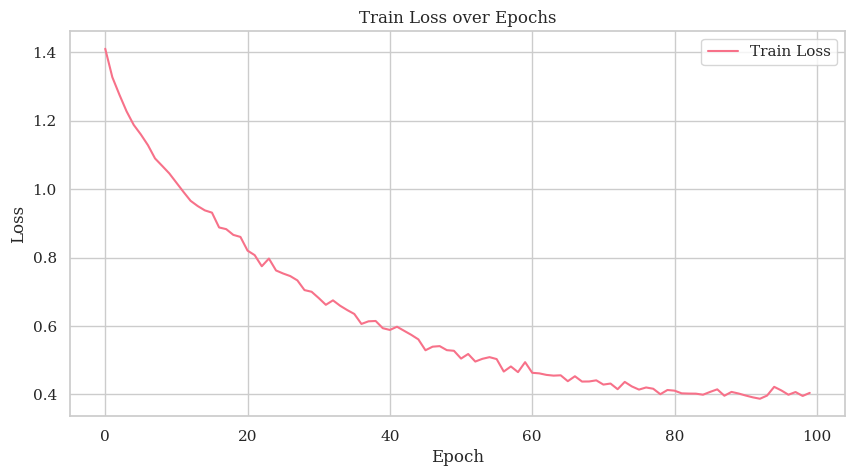

In [47]:
print("Train Accuracy: ", atcnet.score(X_train, np.argmax(y_train, axis=1)))
print("Test Accuracy: ", atcnet.score(X_test, np.argmax(y_test, axis=1)))

train_loss = atcnet.history[:, 'train_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [161]:
test_metrics(atcnet, X_test_noise.astype(np.float32))

3
1
Accuracy:  0.6034704370179949
Precision:  0.6046767259781405
Recall:  0.6034704370179949
F1:  0.602158026378238


In [48]:
callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))]
conformer = NeuralNetClassifier(module=EEGConformer,
        module__n_chans=22,
        module__n_outputs=4,
        module__n_times=1125,
        module__final_fc_length='auto',
        module__add_log_softmax=False,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__betas=(0.5, 0.999),
        optimizer__lr=0.001,
        train_split=None,
        iterator_train__shuffle=True,
        batch_size=32,
        callbacks=callbacks,
        device='cuda' if cuda else 'cpu',
        verbose=verbose
        )
# clf.callbacks.append(TrainEndCheckpoint(dirname=save_dir + f'\\S{subject}'))
conformer.fit(X_train, y_train, epochs=100)

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4424  0.0010  6.6341
      2        1.4159  0.0010  6.4686
      3        1.3982  0.0010  6.5142
      4        1.3475  0.0010  6.4273
      5        1.3188  0.0010  6.5103
      6        1.2872  0.0010  6.4622
      7        1.2743  0.0010  6.5756
      8        1.2682  0.0010  6.5817
      9        1.2515  0.0010  6.5770
     10        1.2337  0.0010  6.5400
     11        1.2207  0.0010  6.6021
     12        1.2145  0.0010  6.6248
     13        1.2005  0.0010  6.7116
     14        1.1705  0.0010  6.7650
     15        1.1531  0.0010  6.7987
     16        1.1470  0.0009  6.8288
     17        1.1022  0.0009  6.9863
     18        1.1227  0.0009  6.8701
     19        1.1057  0.0009  6.9729
     20        1.0822  0.0009  6.9340
     21        1.0769  0.0009  6.9596
     22        1.0735  0.0009  6.9318
     23        1.0518  0.0009  7.0057
     24        1.0405  0.0009  6.8768
     25     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  EEGConformer (EEGConformer)                                  [1, 22, 1125]             [1, 4]                    --                        --
  ├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 22, 1125]          [1, 69, 40]               --                        --
  │    └─Sequential (shallownet): 2-1                          [1, 1, 22, 1125]          [1, 40, 1, 69]            --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 1, 22, 1125]          [1, 40, 22, 1101]         1,040                     [1, 25]
  │    │    └─Conv2d (1): 3-2   

Train Accuracy:  0.9881477398015436
Test Accuracy:  0.4948586118251928


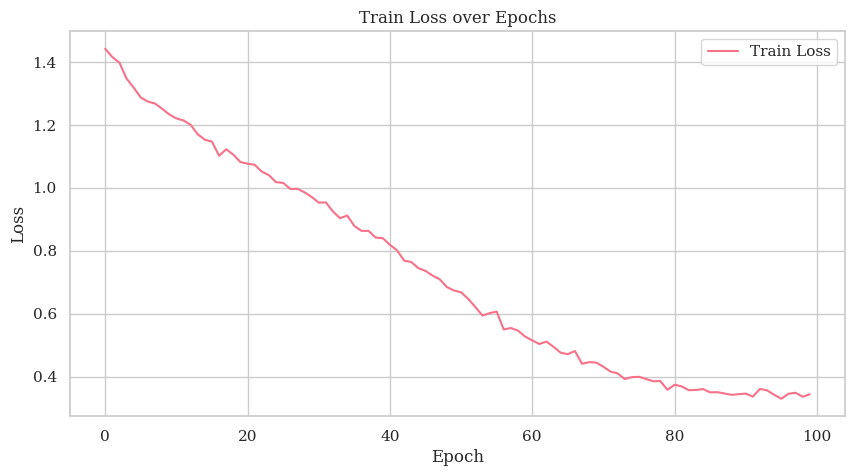

In [49]:
print("Train Accuracy: ", conformer.score(X_train, np.argmax(y_train, axis=1)))
print("Test Accuracy: ", conformer.score(X_test, np.argmax(y_test, axis=1)))

train_loss = conformer.history[:, 'train_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [92]:
test_metrics(conformer)

Accuracy:  0.4948586118251928
Precision:  0.49784871489493626
Recall:  0.4948586118251928
F1:  0.49223409967241627


In [159]:
conformer.predict(X_test_noise.astype(np.float32))

array([3, 3, 3, ..., 2, 0, 3], dtype=int64)

In [160]:
test_metrics(conformer, X_test_noise.astype(np.float32))

3
3
Accuracy:  0.4916452442159383
Precision:  0.4929991784922521
Recall:  0.4916452442159383
F1:  0.4901123139590366


In [50]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes=4
# Extract number of chans and time steps from dataset
n_chans = 22
input_window_samples = 1125

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model.cuda()
    

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [51]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 100

shallowfbcsp = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
shallowfbcsp.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.4052        1.5794  0.0006  0.7279
      2            0.4859        1.4204  0.0006  0.5847
      3            0.5394        1.2885  0.0006  0.5355
      4            0.5411        1.2401  0.0006  0.5395
      5            0.5758        1.2262  0.0006  0.5441
      6            0.5940        1.1580  0.0006  0.5355
      7            0.5562        1.1128  0.0006  0.5411
      8            0.6254        1.0886  0.0006  0.5379
      9            0.6155        1.0591  0.0006  0.5389
     10            0.6320        1.0234  0.0006  0.5381
     11            0.6679        1.0134  0.0006  0.5353
     12            0.6844        0.9850  0.0006  0.5353
     13            0.6695        0.9636  0.0006  0.5327
     14            0.7172        0.9358  0.0006  0.5393
     15            0.7048        0.9071  0.0006  0.5350
     16            0.7202        0.9070  0.0006 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1125, 22]          [1, 40, 1101, 1]          36,240                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
  ├─Expression (conv_nonlin_exp): 

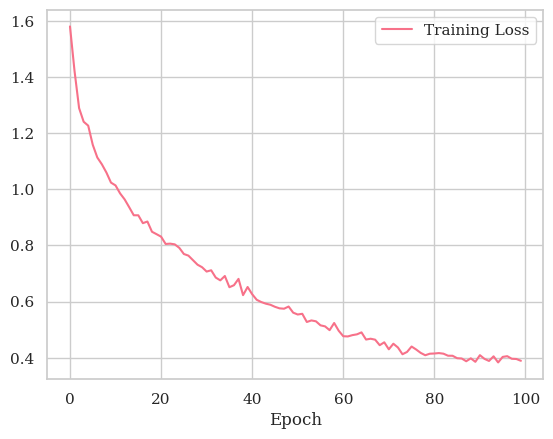

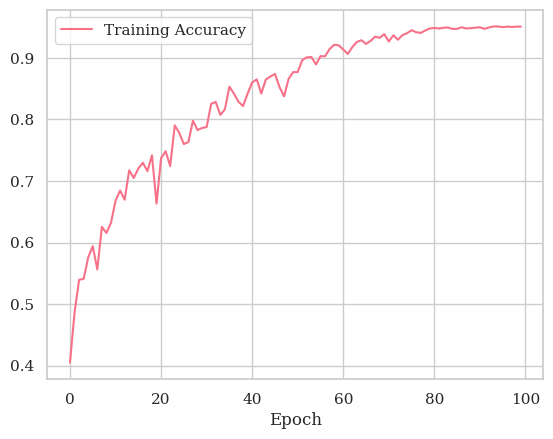

In [52]:
loss = []
acc = []
for a in shallowfbcsp.history:
    loss.append(a['train_loss'])    
    acc.append(a['train_accuracy'])
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [67]:
shallowfbcsp.score(X_test, np.argmax(y_test, axis=1))

0.5893316195372751

In [87]:
test_metrics(shallowfbcsp)

Accuracy:  0.5893316195372751
Precision:  0.5894720855701178
Recall:  0.5893316195372751
F1:  0.5884718140925509


In [152]:
test_metrics(shallowfbcsp, X_test_noise)

3
2
Accuracy:  0.5893316195372751
Precision:  0.5910570409075372
Recall:  0.5893316195372751
F1:  0.5879032902087751


In [53]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 100

eegnetv4 = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
eegnetv4.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: EEGNetv4: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2765        1.4190  0.0006  1.2621
      2            0.2924        1.3599  0.0006  1.0136
      3            0.3206        1.3295  0.0006  1.0067
      4            0.3677        1.2918  0.0006  1.0161
      5            0.4159        1.2691  0.0006  1.0137
      6            0.4388        1.2364  0.0006  1.0385
      7            0.4631        1.2157  0.0006  1.0143
      8            0.4848        1.2022  0.0006  0.9646
      9            0.5102        1.1829  0.0006  0.9863
     10            0.5091        1.1601  0.0006  0.9968
     11            0.5389        1.1446  0.0006  0.9905
     12            0.5557        1.1167  0.0006  0.9935
     13            0.5532        1.0939  0.0006  0.9855
     14            0.5877        1.0754  0.0006  0.9859
     15            0.6023        1.0629  0.0006  0.9853
     16            0.6097        1.0457  0.0006 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  EEGNetv4 (EEGNetv4)                                [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                       [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2                      [1, 22, 1125, 1]          [1, 1, 22, 1125]          --                        --
  ├─Conv2d (conv_temporal): 1-3                      [1, 1, 22, 1125]          [1, 8, 22, 1126]          512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                [1, 8, 22, 1126]          [1, 8, 22, 112

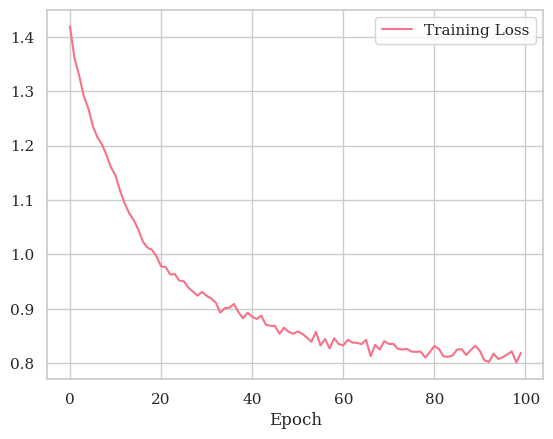

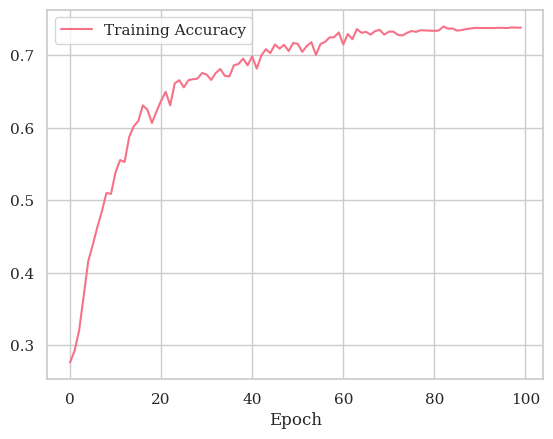

In [54]:
loss = []
acc = []
for a in eegnetv4.history:
    loss.append(a['train_loss'])    
    acc.append(a['train_accuracy'])
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [63]:
eegnetv4.score(X_test, np.argmax(y_test, axis=1))

0.6073264781491002

In [88]:
test_metrics(eegnetv4)

Accuracy:  0.6073264781491002
Precision:  0.6057578458151986
Recall:  0.6073264781491002
F1:  0.6040861839243721


In [153]:
test_metrics(eegnetv4, X_test_noise)

3
3
Accuracy:  0.5449871465295629
Precision:  0.5853292260769479
Recall:  0.5449871465295629
F1:  0.5365044304052046


In [55]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

model = EEGNetv1(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 100

eegnetv1 = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
eegnetv1.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: EEGNetv1: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2552        1.7455  0.0006  2.6086
      2            0.2754        1.6028  0.0006  1.8383
      3            0.2933        1.5232  0.0006  1.8502
      4            0.3068        1.4627  0.0006  1.8682
      5            0.3608        1.4026  0.0006  1.8539
      6            0.3479        1.3678  0.0006  1.8707
      7            0.3558        1.3638  0.0006  1.8462
      8            0.3776        1.3264  0.0006  1.8788
      9            0.3490        1.3186  0.0006  1.8579
     10            0.3586        1.3171  0.0006  1.8906
     11            0.3950        1.2821  0.0006  1.8664
     12            0.3897        1.2755  0.0006  1.8752
     13            0.3749        1.2627  0.0006  1.8493
     14            0.4214        1.2583  0.0006  1.8900
     15            0.4066        1.2497  0.0006  1.8623
     16            0.4110        1.2259  0.0006 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  EEGNetv1 (EEGNetv1)                      [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Conv2d (conv_1): 1-2                   [1, 22, 1125, 1]          [1, 16, 1125, 1]          368                       [1, 1]
  ├─BatchNorm2d (bnorm_1): 1-3             [1, 16, 1125, 1]          [1, 16, 1125, 1]          32                        --
  ├─Expression (elu_1): 1-4                [1, 16, 1125, 1]          [1, 16, 1125, 1]          --                        --
  ├─Expression (permute_1): 1-

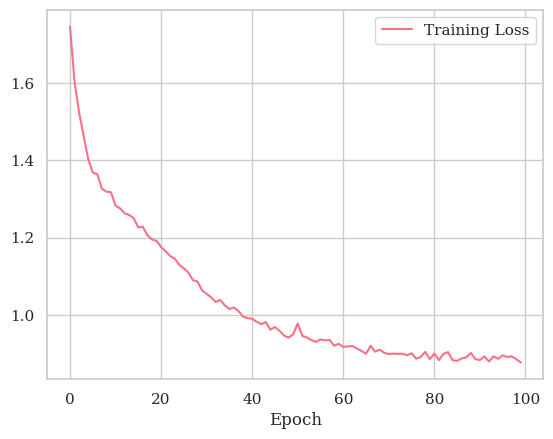

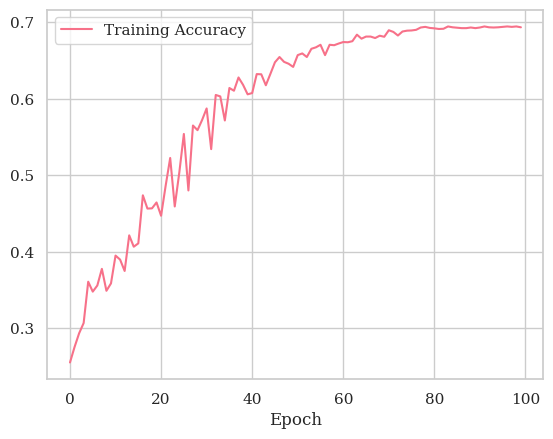

In [56]:
loss = []
acc = []
for a in eegnetv1.history:
    loss.append(a['train_loss'])    
    acc.append(a['train_accuracy'])
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [62]:
eegnetv1.score(X_test, np.argmax(y_test, axis=1))

0.5449871465295629

In [89]:
test_metrics(eegnetv1)


Accuracy:  0.5449871465295629
Precision:  0.5508342296293
Recall:  0.5449871465295629
F1:  0.5420221198135693


In [154]:
test_metrics(eegnetv1, X_test_noise)

3
3
Accuracy:  0.5526992287917738
Precision:  0.5729155151917025
Recall:  0.5526992287917738
F1:  0.5456537782255908


In [57]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

model = Deep4Net(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 100

deep4net = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
deep4net.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2770        1.7866  0.0006  0.8893
      2            0.2952        1.6660  0.0006  0.5538
      3            0.2980        1.6164  0.0006  0.5410
      4            0.2828        1.5958  0.0006  0.5436
      5            0.3104        1.5289  0.0006  0.5519
      6            0.2806        1.5092  0.0006  0.5478
      7            0.3385        1.4635  0.0006  0.5534
      8            0.3299        1.4473  0.0006  0.5538
      9            0.3856        1.4026  0.0006  0.5460
     10            0.4002        1.3614  0.0006  0.5441
     11            0.3768        1.3402  0.0006  0.5414
     12            0.3699        1.3063  0.0006  0.5383
     13            0.3900        1.2782  0.0006  0.5399
     14            0.4245        1.2766  0.0006  0.5359
     15            0.4655        1.2710  0.0006  0.5381
     16            0.4898        1.2547  0.0006 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  Deep4Net (Deep4Net)                      [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1125, 22]          [1, 25, 1116, 1]          14,025                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 25, 1116, 1]          [1, 25, 1116, 1]          50                        --
  ├─Expression (conv_nonlin): 1-5 

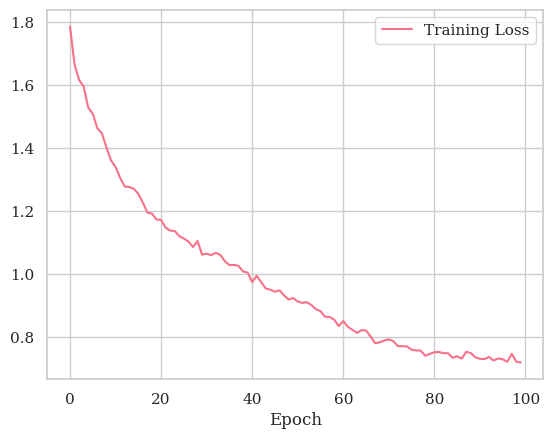

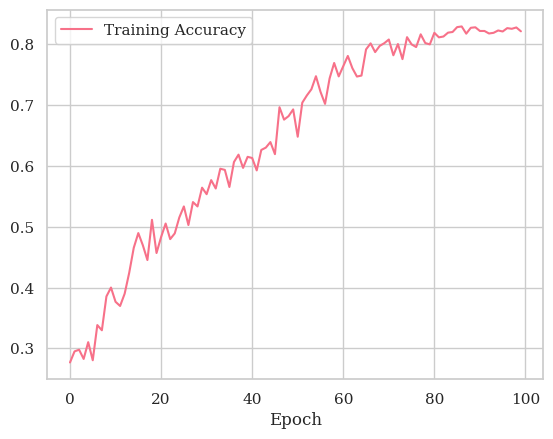

In [58]:
loss = []
acc = []
for a in deep4net.history:
    loss.append(a['train_loss'])    
    acc.append(a['train_accuracy'])
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
deep4net.score(X_test, np.argmax(y_test, axis=1))

In [90]:
test_metrics(deep4net)

Accuracy:  0.5347043701799485
Precision:  0.5519888294346144
Recall:  0.5347043701799485
F1:  0.5223639400423721


In [155]:
test_metrics(deep4net, X_test_noise)

3
1
Accuracy:  0.5302056555269923
Precision:  0.5339961069557776
Recall:  0.5302056555269923
F1:  0.5229806316048469


In [59]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

model = EEGITNet(

    n_classes,
        n_chans,
    input_window_samples=input_window_samples,
)

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 100

eegitnet = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
eegitnet.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: EEGITNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2704        1.4063  0.0006  2.1653
      2            0.2770        1.3535  0.0006  1.7456
      3            0.3120        1.3170  0.0006  1.7704
      4            0.3448        1.2753  0.0006  1.7382
      5            0.3738        1.2592  0.0006  1.7529
      6            0.3911        1.2458  0.0006  1.7293
      7            0.4369        1.2247  0.0006  1.7572
      8            0.4303        1.2107  0.0006  1.7300
      9            0.4405        1.1933  0.0006  1.7325
     10            0.4865        1.1758  0.0006  1.7699
     11            0.5171        1.1459  0.0006  1.7348
     12            0.5289        1.1455  0.0006  1.7508
     13            0.5375        1.1126  0.0006  1.7299
     14            0.5571        1.0984  0.0006  1.7450
     15            0.5684        1.0758  0.0006  1.7375
     16            0.5557        1.0710  0.0006 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  EEGITNet (EEGITNet)                                [1, 22, 1125]             [1, 4]                    --                        --
  ├─Sequential (input_preprocess): 1-1               [1, 22, 1125]             [1, 1, 22, 1125]          --                        --
  │    └─Ensure4d (0): 2-1                           [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  │    └─Rearrange (1): 2-2                          [1, 22, 1125, 1]          [1, 1, 22, 1125]          --                        --
  ├─_InceptionBlock (inception_block): 1-2           [1, 1, 22, 1125]          [1, 14, 1, 1125]   

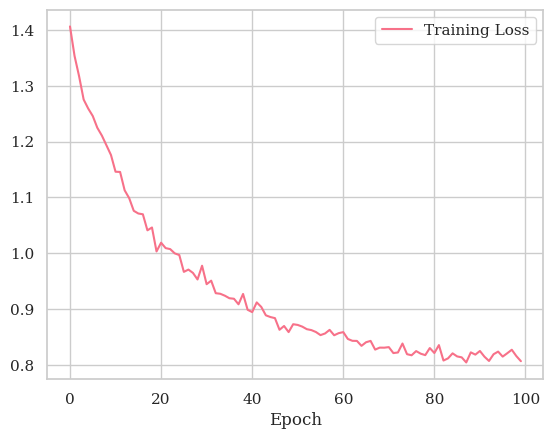

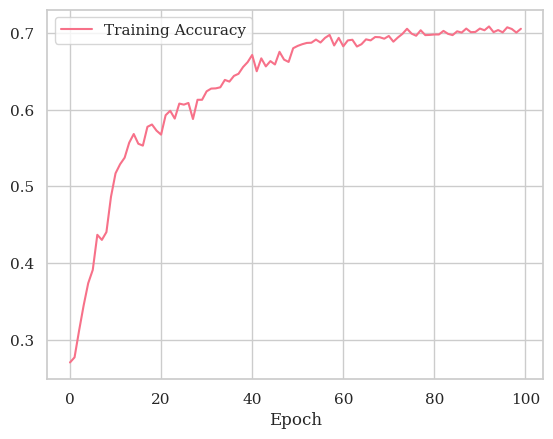

In [60]:
loss = []
acc = []
for a in eegitnet.history:
    loss.append(a['train_loss'])    
    acc.append(a['train_accuracy'])
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [61]:
eegitnet.score(X_test, np.argmax(y_test, axis=1))

0.596401028277635

In [91]:
test_metrics(eegitnet)

Accuracy:  0.596401028277635
Precision:  0.6290589971249566
Recall:  0.596401028277635
F1:  0.5841878635752022


In [156]:
test_metrics(eegitnet, X_test_noise)

3
1
Accuracy:  0.5597686375321337
Precision:  0.6039060825666724
Recall:  0.5597686375321337
F1:  0.5508264924306192


In [30]:
# subjects_windows_dataset = windows_dataset.split('subject')
# n_subjects = len(subjects_windows_dataset.items())
# avg_accuracy = 0

# # iterate over each subject (9 subjects)
# for subject, window_dataset in subjects_windows_dataset.items():
#         # evaluate the model by test accuracy for "Hold-Out" strategy
#         train_dataset = windows_dataset.split('session')['0train']
#         test_dataset = windows_dataset.split('session')['1test']

#         train_X = SliceDataset(train_dataset, idx=0)
#         train_y = SliceDataset(train_dataset, idx=1)
#         test_X = SliceDataset(test_dataset, idx=0)
#         test_y = SliceDataset(test_dataset, idx=1)

#         # create the classifier
#         callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))]
#         clf = NeuralNetClassifier(module=EEGNetv4,
#                 module__n_chans=n_channels,
#                 module__n_outputs=n_classes,
#                 module__n_times=n_times,
#                 module__kernel_length=32,
#                 module__drop_prob=0.5,
#                 criterion=torch.nn.CrossEntropyLoss,
#                 optimizer=torch.optim.Adam,
#                 optimizer__lr=lr,
#                 train_split=None,
#                 iterator_train__shuffle=True,
#                 batch_size=batch_size,
#                 callbacks=callbacks,
#                 device='cuda' if cuda else 'cpu',
#                 verbose=verbose
#                 )
#         clf.callbacks.append(TrainEndCheckpoint(dirname=save_dir + f'\\S{subject}'))
#         clf.fit(train_X, y=train_y, epochs=n_epochs)
        
#         # calculate test accuracy for subject
#         test_accuracy = clf.score(test_X, y=test_y)
#         avg_accuracy += test_accuracy

#         print(f"Subject{subject} test accuracy: {(test_accuracy * 100):.4f}%")
# print(f"Average test accuracy: {(avg_accuracy / n_subjects * 100):.4f}%")

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4392  0.0010  1.4764
      2        1.3972  0.0009  1.0143
      3        1.3840  0.0007  1.0089
      4        1.3505  0.0003  1.0462
      5        1.3401  0.0001  1.0468
      6        1.3344  0.0000  1.0407
Subject1 test accuracy: 27.4691%
  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4503  0.0010  1.0222
      2        1.3869  0.0009  1.0487
      3        1.3628  0.0007  1.0566
      4        1.3417  0.0003  1.0457
      5        1.3414  0.0001  1.0546
      6        1.3285  0.0000  1.0124
Subject2 test accuracy: 25.2701%
  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4802  0.0010  1.0435
      2        1.4096  0.0009  1.0270
      3        1.3810  0.0007  1.0492
      4        1.3518  0.0003  1.0592
      5        1.3569  0.0001  1.0346
      6        1.3532  0.0000  1.0044
Subject3 test accuracy